# **An Improved Harmony Search for Travelling Salesman Problem**

## Objective:
   - Implement an adaptation of Harmony Search (HS) that can be used for Travelling Salesman Problems
   - Improve Harmony Search by using **Elitism** (EHS) to better exploit good solutions
   - Implement an Improved Harmony Search (IHS) aglorithm that makes use of the **Nearest Neighbour** heuristic
   - Try Elitism for the Improved Harmony Search version (EIHS)

## Paper used:
   - Author: Shih-Pang Tseng;
   - Title: An improved harmony search for travelling salesman problem;
   - Year: 2016;
   - Journal: IEE Xplore (pages 299-302);
   - Link: https://ieeexplore.ieee.org/abstract/document/7924712


### Travelling Salesman Problem (TSP)

The **Travelling Salesman Problem (TSP)** is a classic combinatorial optimization problem. The objective is to find the **shortest possible tour** that visits each city **exactly once** and returns to the starting point. TSP is known to be **NP-hard**, meaning that finding an exact solution quickly becomes infeasible as the number of cities increases.



### Why TSP is Unorthodox for Harmony Search

**Harmony Search (HS)** is a metaheuristic inspired by the musical process of searching for a pleasing harmony. It's traditionally well-suited for **continuous optimization problems** where solutions can be fine-tuned using mechanisms like **pitch adjustment**.

However, applying HS to TSP presents challenges:
- **TSP is discrete**, and cities are **identified by indices**, not tunable numeric values.
- **Pitch adjusting doesn't make sense** in this context, as there's no "small adjustment" from city A to city B.
- **Randomization is risky**, as small changes (like swapping cities) can drastically increase the tour length.

To make HS effective for TSP, adjustments are required:
- Replace pitch adjustment with a **nearest neighbor heuristic** (in IHS).
- **Rely heavily on harmony memory** to construct new tours.
- Introduce an **elitist strategy (EHS/EIHS)** to balance **intensification** (focusing on good solutions) and **diversification** (exploring new ones).
- Carefully tune parameters like `r_accept`, `r_elitist`, and `harmony_memory_size`.



### Dataset Source

All datasets used for testing are taken from the [TSPLIB benchmark library](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/), a standard resource for TSP research and comparison.



### Datasets Used

The following **10 benchmark TSP datasets** will be used for testing and result comparison:

- `berlin52` – 52 cities
- `kroE100` – 100 cities
- `a280` – 280 cities
- `d493` – 493 cities
- `d657` – 657 cities
- `pr1002` – 1,002 cities
- `d1291` – 1,291 cities
- `u1432` – 1,432 cities
- `d1655` – 1,655 cities
- `pr2392` – 2,392 cities

## Importing libraries used

In [10]:
import numpy as np
import time
import random
from typing import List, Tuple
import os
import pandas as pd
import matplotlib.pyplot as plt

## Utility functions for TSP

In [3]:

def load_tsp_data(file_name: str) -> List[Tuple[float, float]]:
    """
    Load TSP data from file
    Input:
        file_name: str, name of the file containing TSP data
    Output:
        list of tuples: each tuple contains (x, y) coordinates of a city
    """
    with open(file_name) as f:
        lines = f.readlines()
    data = []
    start_reading = False
    for line in lines:
        if line.strip() == "NODE_COORD_SECTION":
            start_reading = True
            continue
        if start_reading:
            if line.strip() == "EOF":
                break
            parts = line.split()
            data.append((float(parts[1]), float(parts[2])))
    return data

def euclidean_distance(city1: Tuple[float, float], city2: Tuple[float, float]) -> float:
    """
    Calculate the Euclidean distance between two cities
    Input:
        city1: tuple, (x, y) coordinates of city 1
        city2: tuple, (x, y) coordinates of city 2
    Output:
        float: Euclidean distance between the two cities
    """
    return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def random_tour(cities: List[Tuple[float, float]]) -> List[int]:
    """
    Generate a random tour by shuffling the cities
    Input:
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
    Output:
        list of city indices representing the tour
    """
    n = len(cities)
    return np.random.permutation(n).tolist()

def fitness_tsp(tour: List[int], cities: List[Tuple[float, float]]) -> float:
    """
    Calculate the total distance of the tour.
    Input:
        tour: list of city indices representing the tour
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
    Output:
        float: total distance of the tour
    """
    total_distance = 0.0
    n = len(tour)
    for i in range(n):
        total_distance += euclidean_distance(cities[tour[i]], cities[tour[(i + 1) % n]])
    return total_distance

def compute_distance_matrix(cities: List[Tuple[float, float]]) -> np.ndarray:
    """
    Compute the distance matrix for the cities.
    Input:
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
    Output:
        np.ndarray: distance matrix where D[i][j] is the distance between city i and city j
    """
    n = len(cities)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            D[i, j] = D[j, i] = np.hypot(cities[i][0] - cities[j][0],
                                         cities[i][1] - cities[j][1])
    return D

### Harmony Search (HS) for TSP

This function implements a **basic version of Harmony Search (HS)** tailored for solving the **Travelling Salesman Problem (TSP)**. The original HS method is adapted to handle discrete permutations (city tours) rather than continuous variables.


#### Parameters
- `cities`: List of (x, y) coordinates for each city.
- `D`: Precomputed distance matrix between cities.
- `harmony_memory_size`: Number of solutions stored in the Harmony Memory (HM).
- `r_accept`: Probability of choosing a city from the HM rather than selecting randomly.
- `max_iter`: Total number of iterations to run the search.



#### The Algorithm

- **Harmony Memory (HM)**:
  - Initialized with `harmony_memory_size` random tours.
  - Each tour is evaluated using the `fitness_tsp` function (total tour length).
  - HM is sorted by fitness (lower is better).

- **Solution Construction**:
  - A new tour is built one city at a time.
  - With probability `r_accept`, the algorithm tries to choose a city from the same position in random HM members.
  - A **fallback mechanism** ensures the selected city hasn’t been visited:
    - If all candidates are already visited, it chooses the **nearest unvisited city** from the last added city.
  - With probability `1 - r_accept`, a city is picked randomly from the unvisited ones.

- **Memory Update**:
  - If the new tour is better than the worst in HM, it replaces it.
  - HM is kept sorted after every update.

- **Tracking Best Tour**:
  - The best solution found so far (`best_tour`) is updated whenever an improvement occurs.
  - A `history` list tracks the best fitness at each iteration.



In [4]:
def basic_harmony_search_tsp(
    cities: List[Tuple[float, float]],
    D: np.ndarray,
    harmony_memory_size: int,
    r_accept: float,
    max_iter: int
) -> Tuple[List[int], float, List[float]]:
    """
    Basic Harmony Search for TSP
    Input:
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
        D: distance matrix
        harmony_memory_size: size of the harmony memory
        r_accept: probability to choose from harmony memory
        max_iter: number of iterations
    Output:
        best_tour: list of city indices representing the best tour found
        best_f: float, fitness of the best tour
        history: list of fitness values over iterations
    """
    n = len(cities)

    # initialize HM with random tours
    HM = [random.sample(range(n), n) for _ in range(harmony_memory_size)]
    HM_f = [fitness_tsp(t, D) for t in HM]
    HM, HM_f = zip(*sorted(zip(HM, HM_f), key=lambda x: x[1]))
    HM, HM_f = list(HM), list(HM_f)

    best_tour, best_f = HM[0], HM_f[0]
    history = []

    for _ in range(max_iter):
        visited = [False]*n
        new_tour = []
        for j in range(n):
            if random.random() < r_accept:
                # HM consideration
                # collect j-th positions in HM
                pool = [h[j] for h in HM]
                city = None
                # retry harmony memory selection for harmony_memory_size times
                for _ in range(harmony_memory_size):
                    c = random.choice(pool)
                    if not visited[c]:
                        city = c
                        break
                if city is None:
                    # NN fallback from last selected
                    if new_tour:
                        last = new_tour[-1]
                        rem = [i for i,v in enumerate(visited) if not v]
                        city = min(rem, key=lambda x: D[last,x])
                    else:
                        city = random.choice([i for i,v in enumerate(visited) if not v])
                new_tour.append(city)
                visited[city] = True
            else:
                # random choice
                rem = [i for i,v in enumerate(visited) if not v]
                city = random.choice(rem)
                new_tour.append(city)
                visited[city] = True

        new_f = fitness_tsp(new_tour, D)
        # replace worst if improved
        if new_f < HM_f[-1]:
            HM[-1], HM_f[-1] = new_tour, new_f
            HM, HM_f = zip(*sorted(zip(HM, HM_f), key=lambda x: x[1]))
            HM, HM_f = list(HM), list(HM_f)

        if HM_f[0] < best_f:
            best_tour, best_f = HM[0], HM_f[0]
        history.append(best_f)

    return best_tour, best_f, history

### Elitist Harmony Search (EHS)

This version is based on the **Elitist Harmony Search (EHS)** described in the research paper. It extends the basic Harmony Search by dividing the harmony memory into two parts:
- **Elitists** (top solutions): used more frequently to intensify the search
- **Explorers** (remaining solutions): used for maintaining diversity


- Introduces a new parameter `r_elitist`: probability of choosing from the elite group.
- Harmony memory is sorted each iteration.
- When selecting from memory, the algorithm picks from **elitists** or **explorers** based on `r_elitist`.
- When inserting a new solution, it is **inserted in sorted order**, and the worst one is removed.

This structure follows the paper’s attempt to **reduce sensitivity to harmony memory size** and balance intensification/diversification more effectively.

#### Pseudocode from the Paper

```text

1: Initiate Harmony Memory
2: for i = 1 to max number of iterations do
3:     for j = 1 to number of cities do
4:         if rand() < r_accept then
5:             if rand() < r_elitist then
6:                 Choose the next city from Elitists
7:             else
8:                 Choose the next city from Explorers
9:         else
10:            Choose a random city
11:    Insert new harmony into Harmony Memory
12: end for
13: Return the best harmony


In [5]:
def elitist_harmony_search_tsp(
    cities: List[Tuple[float, float]],
    D: np.ndarray,
    harmony_memory_size: int,
    r_accept: float,
    r_elitist: float,
    elitist_size: int,
    max_iter: int
) -> Tuple[List[int], float, List[float]]:
    """
    Elitist Harmony Search for TSP
    Input:
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
        D: distance matrix
        harmony_memory_size: size of the harmony memory
        r_accept: probability to choose from harmony memory
        r_elitist: probability to select from elitist subgroup of HM
        elitist_size: number of elitist solutions in HM
        max_iter: number of iterations
    Output:
        best_tour: list of city indices representing the best tour found
        best_f: float, fitness of the best tour
        history: list of fitness values over iterations
    """
    n = len(cities)
    HM = [random.sample(range(n), n) for _ in range(harmony_memory_size)]
    HM_f = [fitness_tsp(t, D) for t in HM]
    HM, HM_f = zip(*sorted(zip(HM, HM_f), key=lambda x: x[1]))
    HM, HM_f = list(HM), list(HM_f)

    best_tour, best_f = HM[0], HM_f[0]
    history = []

    for _ in range(max_iter):
        visited = [False]*n
        new_tour = []
        for j in range(n):
            if random.random() < r_accept:
                # choose between elitists vs. explorers
                if random.random() < r_elitist:
                    group = HM[:elitist_size]
                else:
                    group = HM[elitist_size:]
                pool = [h[j] for h in group]
                city = None
                for _ in range(harmony_memory_size):
                    c = random.choice(pool)
                    if not visited[c]:
                        city = c
                        break
                if city is None:
                    if new_tour:
                        last = new_tour[-1]
                        rem = [i for i,v in enumerate(visited) if not v]
                        city = min(rem, key=lambda x: D[last,x])
                    else:
                        city = random.choice([i for i,v in enumerate(visited) if not v])
                new_tour.append(city)
                visited[city] = True
            else:
                rem = [i for i,v in enumerate(visited) if not v]
                city = random.choice(rem)
                new_tour.append(city)
                visited[city] = True

        new_f = fitness_tsp(new_tour, D)
        if new_f < HM_f[-1]:
            # insert in sorted order
            idx = next(i for i,f in enumerate(HM_f) if new_f < f)
            HM.insert(idx, new_tour)
            HM_f.insert(idx, new_f)
            HM.pop(); HM_f.pop()

        if HM_f[0] < best_f:
            best_tour, best_f = HM[0], HM_f[0]
        history.append(best_f)

    return best_tour, best_f, history

### Improved Harmony Search (IHS) for TSP

This version modifies the basic Harmony Search by introducing a TSP-specific adjustment to replace the pitch adjustment mechanism, which doesn't apply well to permutations.

- Adds a new parameter `r_pitch`: the probability of applying a **Nearest Neighbor (NN)** heuristic when a city is chosen from memory.
- If `r_pitch` is triggered and the partial tour is non-empty:
  - The next city is selected as the **nearest unvisited neighbor** of the last city in the current tour (pitch-adjustment replacement).
- This helps improve convergence by incorporating TSP-specific knowledge and generating more locally optimized tours.
- Choosing a very big value for r_pitch can lead to a **greedy algorithm** that may not explore enough and get stuck in local minima very fast.
- Decided to use `r_pitch = 0.01` for the IHS implementation, as it provides a good balance between exploration and exploitation.


In [6]:
def improved_harmony_search(
    cities: List[Tuple[float, float]],
    D: np.ndarray,
    harmony_memory_size: int,
    r_accept: float,
    r_pitch: float,
    max_iter: int
) -> Tuple[List[int], float, List[float]]:
    """
    Improved Harmony Search for TSP
    Input:
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
        D: distance matrix
        harmony_memory_size: size of the harmony memory
        r_accept: probability to choose from harmony memory
        r_pitch: probability to use NN pitch-adjust
        max_iter: number of iterations
    Output:
        best_tour: list of city indices representing the best tour found
        best_f: float, fitness of the best tour
        history: list of fitness values over iterations
    """
    n = len(cities)
    # Initialize harmony memory with random tours
    HM = [random.sample(range(n), n) for _ in range(harmony_memory_size)]
    HM_f = [sum(D[t[i], t[(i+1)%n]] for i in range(n)) for t in HM]
    HM, HM_f = zip(*sorted(zip(HM, HM_f), key=lambda x: x[1]))
    HM, HM_f = list(HM), list(HM_f)

    best_tour, best_f = HM[0], HM_f[0]
    history = []

    for _ in range(max_iter):
        visited = [False]*n
        new_tour = []
        for j in range(n):
            if random.random() < r_accept:
                # HM consideration
                if random.random() < r_pitch and new_tour:
                    # pitch-adjust: NN from last city
                    last = new_tour[-1]
                    rem = [i for i, v in enumerate(visited) if not v]
                    city = min(rem, key=lambda x: D[last, x])
                else:
                    # memory consideration
                    pool = [h[j] for h in HM]
                    city = None
                    for _ in range(harmony_memory_size):
                        c = random.choice(pool)
                        if not visited[c]:
                            city = c
                            break
                    # fallback to NN or random if needed
                    if city is None:
                        if new_tour:
                            last = new_tour[-1]
                            rem = [i for i, v in enumerate(visited) if not v]
                            city = min(rem, key=lambda x: D[last, x])
                        else:
                            city = random.choice([i for i, v in enumerate(visited) if not v])
                new_tour.append(city)
                visited[city] = True
            else:
                # randomization
                rem = [i for i, v in enumerate(visited) if not v]
                city = random.choice(rem)
                new_tour.append(city)
                visited[city] = True

        new_f = sum(D[new_tour[i], new_tour[(i+1)%n]] for i in range(n))
        # replace worst if improved
        if new_f < HM_f[-1]:
            HM[-1], HM_f[-1] = new_tour, new_f
            HM, HM_f = zip(*sorted(zip(HM, HM_f), key=lambda x: x[1]))
            HM, HM_f = list(HM), list(HM_f)
        if HM_f[0] < best_f:
            best_tour, best_f = HM[0], HM_f[0]
        history.append(best_f)

    return best_tour, best_f, history


### Elitist Improved Harmony Search (EIHS) for TSP

This version combines the mechanisms of both **Improved Harmony Search (IHS)** and **Elitist Harmony Search (EHS)**.

- Adds elitism: the memory is split into **elitists** and **explorers**.



In [7]:
def elitist_improved_harmony_search(
    cities: List[Tuple[float, float]],
    D: np.ndarray,
    harmony_memory_size: int,
    r_accept: float,
    r_pitch: float,
    r_elitist: float,
    elitist_size: int,
    max_iter: int
) -> Tuple[List[int], float, List[float]]:
    """
    Elitist Improved Harmony Search for TSP
    Input:
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
        D: distance matrix
        harmony_memory_size: size of the harmony memory
        r_accept: probability to choose from harmony memory
        r_pitch: probability to use NN pitch-adjust
        r_elitist: probability to select from elitist subgroup of HM
        elitist_size: number of elitist solutions in HM
        max_iter: number of iterations
    Output:
        best_tour: list of city indices representing the best tour found
        best_f: float, fitness of the best tour
        history: list of fitness values over iterations
    """
    n = len(cities)
    HM = [random.sample(range(n), n) for _ in range(harmony_memory_size)]
    HM_f = [sum(D[t[i], t[(i+1)%n]] for i in range(n)) for t in HM]
    HM, HM_f = zip(*sorted(zip(HM, HM_f), key=lambda x: x[1]))
    HM, HM_f = list(HM), list(HM_f)

    best_tour, best_f = HM[0], HM_f[0]
    history: List[float] = []

    for _ in range(max_iter):
        visited = [False] * n
        new_tour = []

        for j in range(n):
            if random.random() < r_accept:
                if random.random() < r_pitch and new_tour:
                    # NN pitch-adjust
                    last = new_tour[-1]
                    rem = [i for i, v in enumerate(visited) if not v]
                    city = min(rem, key=lambda x: D[last, x])
                else:
                    # Elitist vs. explorer group
                    if random.random() < r_elitist:
                        group = HM[:elitist_size]
                    else:
                        group = HM[elitist_size:]
                    pool = [h[j] for h in group]
                    city = None
                    for _ in range(harmony_memory_size):
                        c = random.choice(pool)
                        if not visited[c]:
                            city = c
                            break
                    if city is None:
                        if new_tour:
                            last = new_tour[-1]
                            rem = [i for i, v in enumerate(visited) if not v]
                            city = min(rem, key=lambda x: D[last, x])
                        else:
                            rem = [i for i, v in enumerate(visited) if not v]
                            city = random.choice(rem)
                new_tour.append(city)
                visited[city] = True
            else:
                rem = [i for i, v in enumerate(visited) if not v]
                city = random.choice(rem)
                new_tour.append(city)
                visited[city] = True

        # Evaluate new harmony
        new_f = sum(D[new_tour[i], new_tour[(i+1)%n]] for i in range(n))

        # Insert if better than worst in HM
        if new_f < HM_f[-1]:
            # find insertion position
            idx = next(i for i, f in enumerate(HM_f) if new_f < f)
            HM.insert(idx, new_tour)
            HM_f.insert(idx, new_f)
            # maintain size
            HM.pop()
            HM_f.pop()

        if HM_f[0] < best_f:
            best_tour, best_f = HM[0], HM_f[0]

        history.append(best_f)

    return best_tour, best_f, history

In [47]:
def run_harmony_search_tests(tsp_file: str, max_iter: int, output_file: str = "results_table.csv") -> None:
    """
    Runs tests for the 4 Harmony Search algorithms (HS, EHS, IHS, EIHS) on a given TSP file.

    Args:
        tsp_file: The path to the TSP file.
        max_iter: The number of iterations to run for each algorithm.
        output_file: The path to save the results table as a CSV file.

    Outputs:
        Appends the results to a CSV file.
        Saves a convergence plot for the dataset.
    """
    cities = load_tsp_data(tsp_file)
    D = compute_distance_matrix(cities)

    harmony_memory_size = 20
    r_accept = 0.999
    r_elitist = 0.9
    elitist_size = 4
    r_pitch = 0.01

    results = []
    convergence_data = {}

    # Run Harmony Search (HS)
    start_hs = time.time()
    hs_tour, hs_dist, hs_hist = basic_harmony_search_tsp(
        cities, D,
        harmony_memory_size=harmony_memory_size,
        r_accept=r_accept,
        max_iter=max_iter
    )
    end_hs = time.time()
    hs_time = end_hs - start_hs
    print(f"HS best distance: {hs_dist}, Time: {hs_time:.2f} seconds")
    results.append({"Algorithm": "HS", "Dataset": tsp_file.split('/')[-1], "Best Distance": hs_dist, "Time (s)": hs_time})
    convergence_data["HS"] = hs_hist

    # Run Elitist Harmony Search (EHS)
    start_ehs = time.time()
    ehs_tour, ehs_dist, ehs_hist = elitist_harmony_search_tsp(
        cities, D,
        harmony_memory_size=harmony_memory_size,
        r_accept=r_accept,
        r_elitist=r_elitist,
        elitist_size=elitist_size,
        max_iter=max_iter
    )
    end_ehs = time.time()
    ehs_time = end_ehs - start_ehs
    print(f"EHS best distance: {ehs_dist}, Time: {ehs_time:.2f} seconds")
    results.append({"Algorithm": "EHS", "Dataset": tsp_file.split('/')[-1], "Best Distance": ehs_dist, "Time (s)": ehs_time})
    convergence_data["EHS"] = ehs_hist

    # Run Improved Harmony Search (IHS)
    start_ihs = time.time()
    ihs_tour, ihs_dist, ihs_hist = improved_harmony_search(
        cities, D,
        harmony_memory_size=harmony_memory_size,
        r_accept=r_accept,
        r_pitch=r_pitch,
        max_iter=max_iter
    )
    end_ihs = time.time()
    ihs_time = end_ihs - start_ihs
    print(f"IHS best distance: {ihs_dist}, Time: {ihs_time:.2f} seconds")
    results.append({"Algorithm": "IHS", "Dataset": tsp_file.split('/')[-1], "Best Distance": ihs_dist, "Time (s)": ihs_time})
    convergence_data["IHS"] = ihs_hist

    # Run Elitist Improved Harmony Search (EIHS)
    start_eihs = time.time()
    eihs_tour, eihs_dist, eihs_hist = elitist_improved_harmony_search(
        cities, D,
        harmony_memory_size=harmony_memory_size,
        r_accept=r_accept,
        r_pitch=r_pitch,
        r_elitist=r_elitist,
        elitist_size=elitist_size,
        max_iter=max_iter
    )
    end_eihs = time.time()
    eihs_time = end_eihs - start_eihs
    print(f"EIHS best distance: {eihs_dist}, Time: {eihs_time:.2f} seconds")
    results.append({"Algorithm": "EIHS", "Dataset": tsp_file.split('/')[-1], "Best Distance": eihs_dist, "Time (s)": eihs_time})
    convergence_data["EIHS"] = eihs_hist

    # Save results to CSV
    df = pd.DataFrame(results)
    if not os.path.exists(output_file):
        df.to_csv(output_file, index=False)
    else:
        df.to_csv(output_file, mode='a', header=False, index=False)

    print(f"Results for {tsp_file.split('/')[-1]} saved to {output_file}")

    # Plot convergence
    plt.figure(figsize=(10, 6))
    for algo, hist in convergence_data.items():
        plt.plot(hist, label=algo)
    plt.xlabel("Iteration")
    plt.ylabel("Best Distance")
    plt.title(f'Convergence of Harmony Search Algorithms on {tsp_file.split("/")[-1].split(".")[0]}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Ensure the plots directory exists
    os.makedirs("plots", exist_ok=True)
    plot_file = f"plots/convergence_{tsp_file.split('/')[-1].split('.')[0]}.png"
    plt.savefig(plot_file)
    print(f"Convergence plot saved to {plot_file}")
    plt.close()

## Testing parameters for the Harmony Search functions

In [70]:
def test_harmony_search_with_varying_r_accepts(
    cities: List[Tuple[float, float]],
    D: np.ndarray,
    r_accepts: List[float],
    harmony_memory_size: int,
    max_iter: int
) -> None:
    """
    Test the classic harmony search algorithm with varying r_accept values.

    Args:
        cities: List of tuples representing city coordinates.
        D: Distance matrix.
        r_accepts: List of r_accept values to test.
        harmony_memory_size: Fixed harmony memory size.
        max_iter: Number of iterations.

    Returns:
        None. Displays a line plot of results.
    """
    results = []

    for r_accept in r_accepts:
        print(f"Testing with r_accept: {r_accept}")
        _, best_distance, _ = basic_harmony_search_tsp(
            cities, D, harmony_memory_size=harmony_memory_size, r_accept=r_accept, max_iter=max_iter
        )
        results.append((r_accept, best_distance))
        print(f"Best distance for r_accept {r_accept}: {best_distance}")

    r_accept_values = [result[0] for result in results]
    distances = [result[1] for result in results]

    plt.figure(figsize=(10, 6))
    plt.plot(r_accept_values, distances, marker='o', color='blue', label='Best Distance')
    plt.xlabel("r_accept")
    plt.ylabel("Best Distance")
    plt.title("Performance of Harmony Search with Varying r_accept Values")
    plt.grid(True)
    plt.legend()
    plt.show()

#### Testing for different `r_accepts`
   - Ran tests with 6 values of r_accepts on 4 different datasets
   - Parameters used:
     - `r_accept` values tested: [0.8, 0.85, 0.9, 0.95, 0.99, 0.999]
     - `harmony_memory_size = 20`
     - `max_iter = 1000`
##### Conclusion for parameter
- The best results were consistently obtained with `r_accept = 0.999`, especially on larger TSP datasets.
- This is because:
  - A higher `r_accept` means the algorithm relies more heavily on solutions from the existing harmony memory rather than randomization.
  - TSP is **highly sensitive to randomness** even small random changes (like swapping two cities) can drastically worsen the tour.
  - By setting `r_accept = 0.999`, almost all decisions during solution construction come from the memory, which helps preserve and exploit good partial tours.
  - This leads to **faster convergence** and **higher-quality solutions**, particularly for larger instances where random components are more likely to disrupt promising structures.


In [ ]:
# Values to test for
r_accepts = [0.8, 0.85, 0.9, 0.95, 0.99, 0.999]
harmony_memory_size = 20
max_iter = 1000

Testing with r_accept: 0.8
Best distance for r_accept 0.8: 130886.0084664669
Testing with r_accept: 0.85
Best distance for r_accept 0.85: 120472.88237066338
Testing with r_accept: 0.9
Best distance for r_accept 0.9: 104533.71165058951
Testing with r_accept: 0.95
Best distance for r_accept 0.95: 105210.45078230384
Testing with r_accept: 0.99
Best distance for r_accept 0.99: 75892.89378531552
Testing with r_accept: 0.999
Best distance for r_accept 0.999: 83716.30817274498


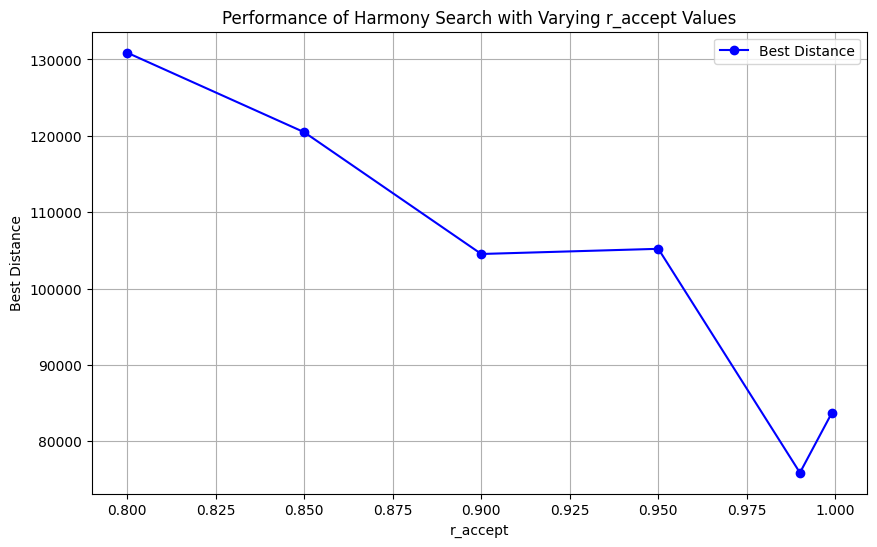

In [81]:
cities = load_tsp_data("data/tsp/kroE100.tsp")
D = compute_distance_matrix(cities)

test_harmony_search_with_varying_r_accepts(cities, D, r_accepts, harmony_memory_size, max_iter)

Testing with r_accept: 0.8
Best distance for r_accept 0.8: 290119.9278958367
Testing with r_accept: 0.85
Best distance for r_accept 0.85: 288417.18681847263
Testing with r_accept: 0.9
Best distance for r_accept 0.9: 278733.3147635274
Testing with r_accept: 0.95
Best distance for r_accept 0.95: 267816.1153434009
Testing with r_accept: 0.99
Best distance for r_accept 0.99: 208254.09362881075
Testing with r_accept: 0.999
Best distance for r_accept 0.999: 206421.83918668522


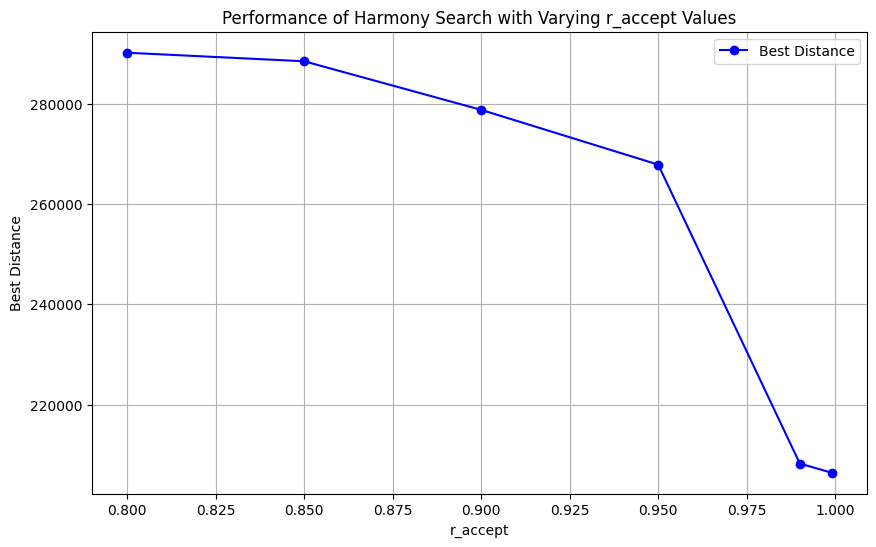

In [79]:
cities = load_tsp_data("data/tsp/d493.tsp")
D = compute_distance_matrix(cities)

test_harmony_search_with_varying_r_accepts(cities, D, r_accepts, harmony_memory_size, max_iter)

Testing with r_accept: 0.8
Best distance for r_accept 0.8: 5437162.8101893
Testing with r_accept: 0.85
Best distance for r_accept 0.85: 5448976.097376593
Testing with r_accept: 0.9
Best distance for r_accept 0.9: 5237625.2485913895
Testing with r_accept: 0.95
Best distance for r_accept 0.95: 4857370.97517146
Testing with r_accept: 0.99
Best distance for r_accept 0.99: 3817191.8649160247
Testing with r_accept: 0.999
Best distance for r_accept 0.999: 3478853.6901885797


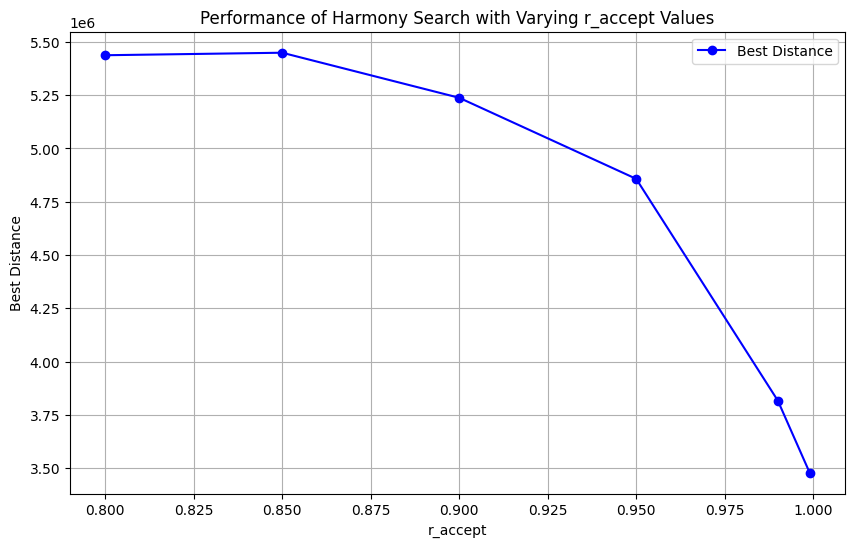

In [75]:
cities = load_tsp_data("data/tsp/pr1002.tsp")
D = compute_distance_matrix(cities)

test_harmony_search_with_varying_r_accepts(cities, D, r_accepts, harmony_memory_size, max_iter)

Testing with r_accept: 0.8
Best distance for r_accept 0.8: 1811546.234538334
Testing with r_accept: 0.85
Best distance for r_accept 0.85: 1765900.1102748406
Testing with r_accept: 0.9
Best distance for r_accept 0.9: 1732625.0842591415
Testing with r_accept: 0.95
Best distance for r_accept 0.95: 1599133.0446523726
Testing with r_accept: 0.99
Best distance for r_accept 0.99: 1246377.0596234149
Testing with r_accept: 0.999
Best distance for r_accept 0.999: 1188551.3746331702


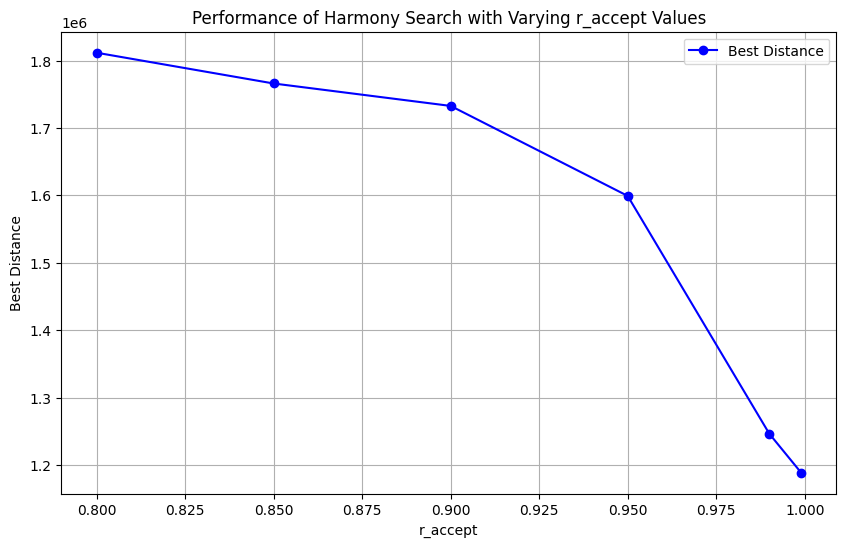

In [78]:
cities = load_tsp_data("data/tsp/d1655.tsp")
D = compute_distance_matrix(cities)

test_harmony_search_with_varying_r_accepts(cities, D, r_accepts, harmony_memory_size, max_iter)

In [61]:
def test_harmony_search_with_varying_hms(
    cities: List[Tuple[float, float]],
    D: np.ndarray,
    harmony_sizes: List[int],
    r_accept: float,
    max_iter: int
) -> None:
    """
    Test the classic harmony search algorithm with varying harmony memory sizes.

    Args:
        cities: List of tuples representing city coordinates.
        D: Distance matrix.
        harmony_sizes: List of harmony memory sizes to test.
        r_accept: Acceptance rate for harmony search.
        max_iter: Number of iterations.

    Returns:
        None. Displays a bar plot of results.
    """
    results = []

    for hms in harmony_sizes:
        print(f"Testing with harmony memory size: {hms}")
        _, best_distance, _ = basic_harmony_search_tsp(
            cities, D, harmony_memory_size=hms, r_accept=r_accept, max_iter=max_iter
        )
        results.append((hms, best_distance))
        print(f"Best distance for harmony memory size {hms}: {best_distance}")

    sizes = [result[0] for result in results]
    distances = [result[1] for result in results]

    plt.figure(figsize=(10, 6))
    plt.bar(sizes, distances, color='skyblue', edgecolor='black')
    plt.xlabel("Harmony Memory Size")
    plt.ylabel("Best Distance")
    plt.title("Performance of Harmony Search with Varying Harmony Memory Sizes")
    plt.xticks(sizes)
    plt.show()

#### Testing for different `harmony memory sizes`
- Ran tests with 6 values of `harmony_memory_size` on 4 TSP datasets
- Parameters used:
  - `harmony_memory_size` values: [5, 10, 15, 20, 25, 30]
  - `r_accept = 0.999`
  - `max_iter = 1000`

##### Conclusion for parameter
- Results were varied across datasets.
- Based on the bar plots, **size 20** got ok results in all test, so I chose it for consistency with the paper.
- As the paper explains, TSP is sensitive to harmony memory size:
  - Too small → high intensification → risk of premature convergence.
  - Too large → too much diversification → slower progress.
- Since pitch adjusting is not usable for TSP, harmony memory is the only way to balance intensification and diversification.
- Size 20 is a good trade-off and supported by the paper’s own experimental setup.

In [ ]:
harmony_sizes = [5, 10, 15, 20, 25, 30]
r_accept = 0.999
max_iter = 1000

Testing with harmony memory size: 5
Best distance for harmony memory size 5: 90115.03371891077
Testing with harmony memory size: 10
Best distance for harmony memory size 10: 92431.26602003696
Testing with harmony memory size: 15
Best distance for harmony memory size 15: 92162.66804700407
Testing with harmony memory size: 20
Best distance for harmony memory size 20: 82577.9472521019
Testing with harmony memory size: 25
Best distance for harmony memory size 25: 82016.2109618193
Testing with harmony memory size: 30
Best distance for harmony memory size 30: 82459.04035410697


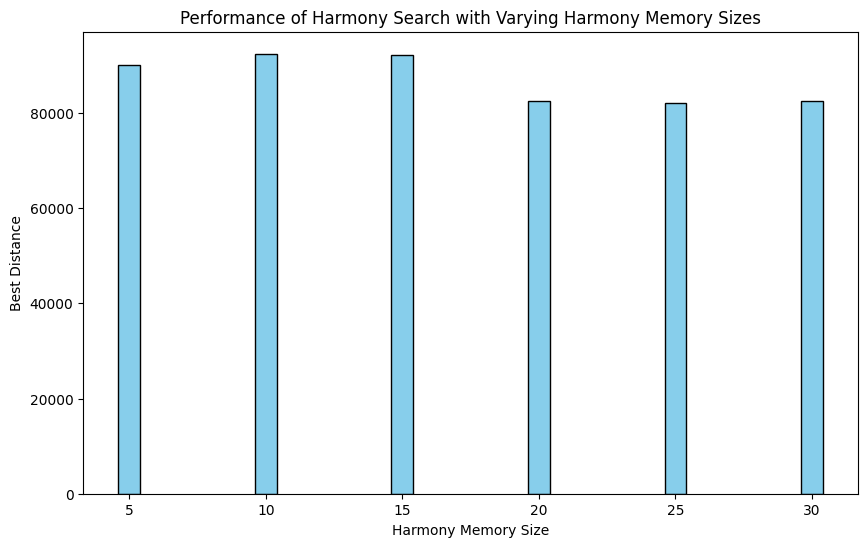

In [85]:
cities = load_tsp_data("data/tsp/kroE100.tsp")
D = compute_distance_matrix(cities)

test_harmony_search_with_varying_hms(cities, D, harmony_sizes, r_accept, max_iter)

Testing with harmony memory size: 5
Best distance for harmony memory size 5: 199844.4207653104
Testing with harmony memory size: 10
Best distance for harmony memory size 10: 192211.29179207358
Testing with harmony memory size: 15
Best distance for harmony memory size 15: 191872.7904769555
Testing with harmony memory size: 20
Best distance for harmony memory size 20: 194735.89190283878
Testing with harmony memory size: 25
Best distance for harmony memory size 25: 206694.88131985546
Testing with harmony memory size: 30
Best distance for harmony memory size 30: 213700.57329382063


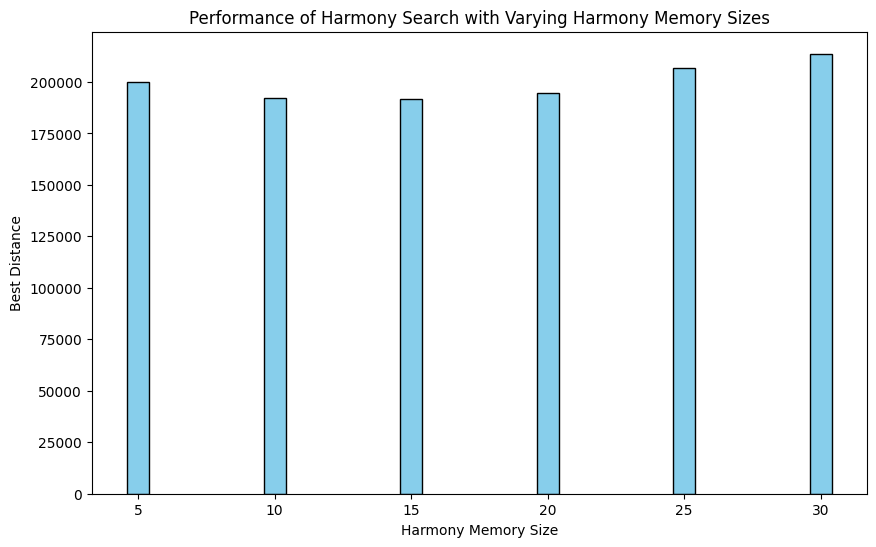

In [87]:
cities = load_tsp_data("data/tsp/d493.tsp")
D = compute_distance_matrix(cities)

test_harmony_search_with_varying_hms(cities, D, harmony_sizes, r_accept, max_iter)

Testing with harmony memory size: 5
Best distance for harmony memory size 5: 3515454.4672180125
Testing with harmony memory size: 10
Best distance for harmony memory size 10: 3427238.797860233
Testing with harmony memory size: 15
Best distance for harmony memory size 15: 3449538.757543502
Testing with harmony memory size: 20
Best distance for harmony memory size 20: 3515486.605575623
Testing with harmony memory size: 25
Best distance for harmony memory size 25: 3768046.149338305
Testing with harmony memory size: 30
Best distance for harmony memory size 30: 3954935.048078514


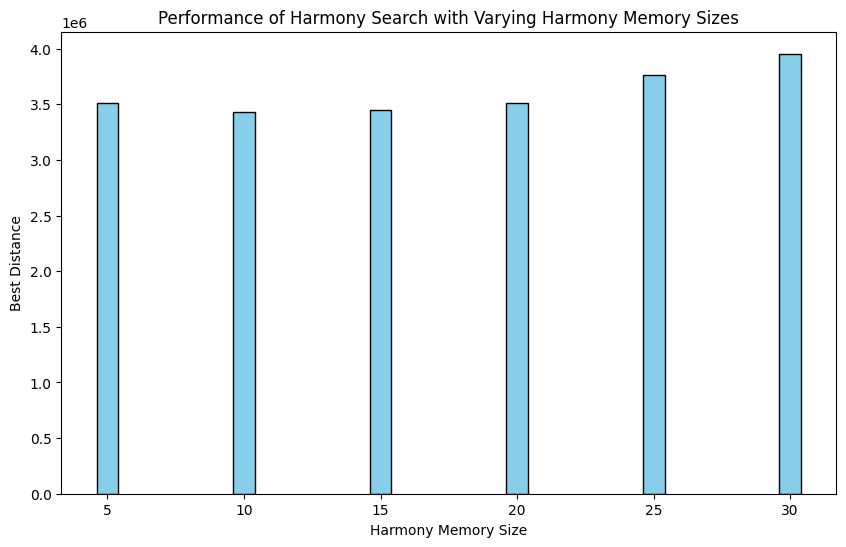

In [89]:
cities = load_tsp_data("data/tsp/pr1002.tsp")
D = compute_distance_matrix(cities)

test_harmony_search_with_varying_hms(cities, D, harmony_sizes, r_accept, max_iter)

Testing with harmony memory size: 5
Best distance for harmony memory size 5: 1149046.4323127093
Testing with harmony memory size: 10
Best distance for harmony memory size 10: 1139633.644156954
Testing with harmony memory size: 15
Best distance for harmony memory size 15: 1203529.155104059
Testing with harmony memory size: 20
Best distance for harmony memory size 20: 1166922.892632228
Testing with harmony memory size: 25
Best distance for harmony memory size 25: 1263298.6217211643
Testing with harmony memory size: 30
Best distance for harmony memory size 30: 1259448.8874643745


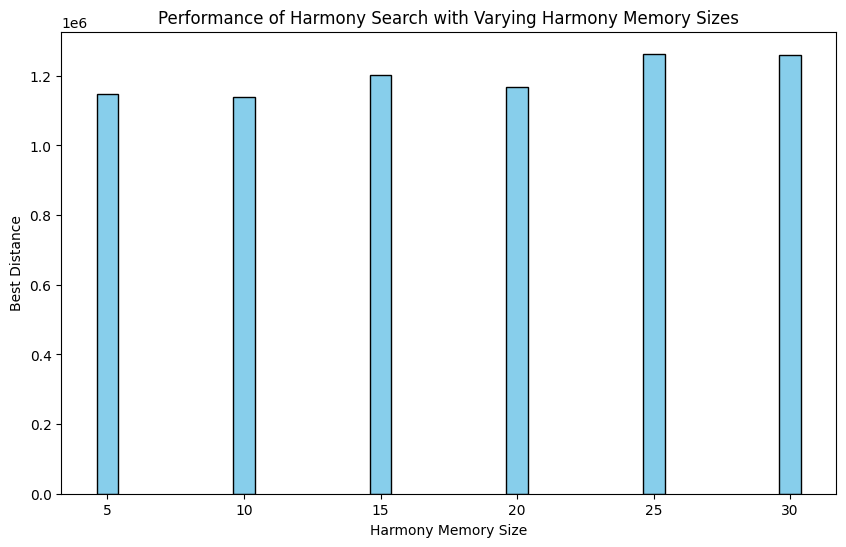

In [88]:
cities = load_tsp_data("data/tsp/d1655.tsp")
D = compute_distance_matrix(cities)

test_harmony_search_with_varying_hms(cities, D, harmony_sizes, r_accept, max_iter)

In [ ]:
def test_elitist_harmony_with_varying_r_elitist(
    cities: List[Tuple[float, float]],
    D: np.ndarray,
    r_elitist_values: List[float],
    harmony_memory_size: int,
    r_accept: float,
    elitist_size: int,
    max_iter: int
) -> None:
    """
    Test the elitist harmony search algorithm with varying r_elitist values.

    Args:
        cities: List of tuples representing city coordinates.
        D: Distance matrix.
        r_elitist_values: List of r_elitist values to test.
        harmony_memory_size: Fixed harmony memory size.
        r_accept: Fixed acceptance rate.
        elitist_size: Fixed number of elitist solutions.
        max_iter: Number of iterations.

    Returns:
        None. Displays a line plot of results.
    """
    results = []

    for r_elitist in r_elitist_values:
        print(f"Testing with r_elitist: {r_elitist}")
        _, best_distance, _ = elitist_harmony_search_tsp(
            cities, D,
            harmony_memory_size=harmony_memory_size,
            r_accept=r_accept,
            r_elitist=r_elitist,
            elitist_size=elitist_size,
            max_iter=max_iter
        )
        results.append((r_elitist, best_distance))
        print(f"Best distance for r_elitist {r_elitist}: {best_distance}")

    r_elitist_values = [result[0] for result in results]
    distances = [result[1] for result in results]

    plt.figure(figsize=(10, 6))
    plt.plot(r_elitist_values, distances, marker='o', color='blue', label='Best Distance')
    plt.xlabel("r_elitist")
    plt.ylabel("Best Distance")
    plt.title("Performance of Elitist Harmony Search with Varying r_elitist Values")
    plt.grid(True)
    plt.legend()
    plt.show()

#### Testing for different `r_elitist` values
- Ran tests with several `r_elitist` values on 5 TSP datasets
- Parameters used:
  - `r_elitist` values tested: [0.3, 0.5, 0.7, 0.8, 0.9, 0.99]
  - `harmony_memory_size = 20`
  - `r_accept = 0.999`
  - `max_iter = 1000`

##### Conclusion for parameter
- The best results were observed in the **0.8–0.9 range**.
- I chose **`r_elitist = 0.9`** because:
  - It performed better on the larger TSP instances.
  - It matches the value used in the reference paper.
- As explained in the paper, `r_elitist` controls how often cities are chosen from the top-performing (elite) harmonies. A higher value increases intensification, which helps focus the search and stabilize the convergence process.


In [ ]:
# The r_elitist values to test
r_elitist_values = [0.3, 0.5, 0.7, 0.8, 0.9, 0.99]

# Fixed parameters
harmony_memory_size = 20
r_accept = 0.999
elitist_size = 4
max_iter = 1000


Testing with r_elitist: 0.3
Best distance for r_elitist 0.3: 79777.66754959564
Testing with r_elitist: 0.5
Best distance for r_elitist 0.5: 89841.39055312671
Testing with r_elitist: 0.7
Best distance for r_elitist 0.7: 101057.99422660893
Testing with r_elitist: 0.8
Best distance for r_elitist 0.8: 86824.52911265634
Testing with r_elitist: 0.9
Best distance for r_elitist 0.9: 89754.76992040344
Testing with r_elitist: 0.99
Best distance for r_elitist 0.99: 88104.17973836552


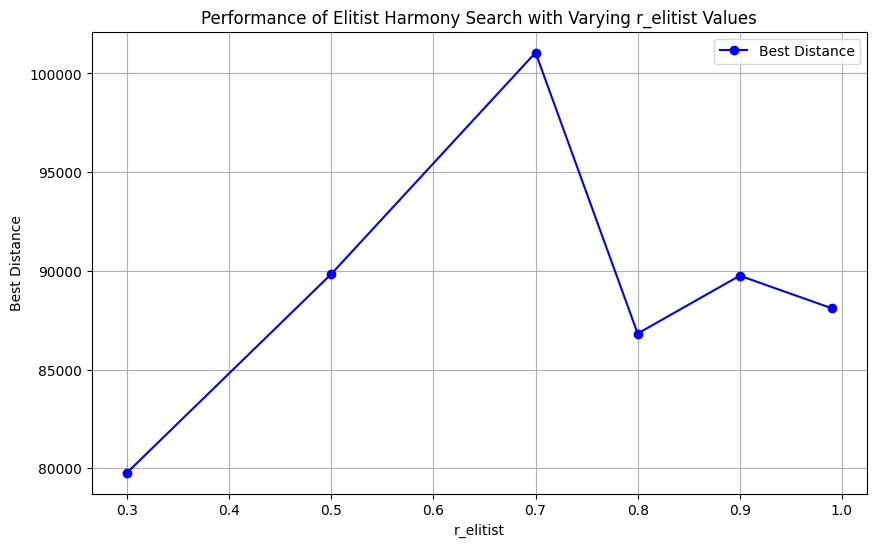

In [98]:
cities = load_tsp_data("data/tsp/kroE100.tsp")
D = compute_distance_matrix(cities)

test_elitist_harmony_with_varying_r_elitist(
    cities, D, r_elitist_values, harmony_memory_size, r_accept, elitist_size, max_iter)

Testing with r_elitist: 0.3
Best distance for r_elitist 0.3: 195490.84661785435
Testing with r_elitist: 0.5
Best distance for r_elitist 0.5: 210670.3701818128
Testing with r_elitist: 0.7
Best distance for r_elitist 0.7: 200632.44543847692
Testing with r_elitist: 0.8
Best distance for r_elitist 0.8: 192756.78110807302
Testing with r_elitist: 0.9
Best distance for r_elitist 0.9: 191659.2480124866
Testing with r_elitist: 0.99
Best distance for r_elitist 0.99: 199306.61004167612


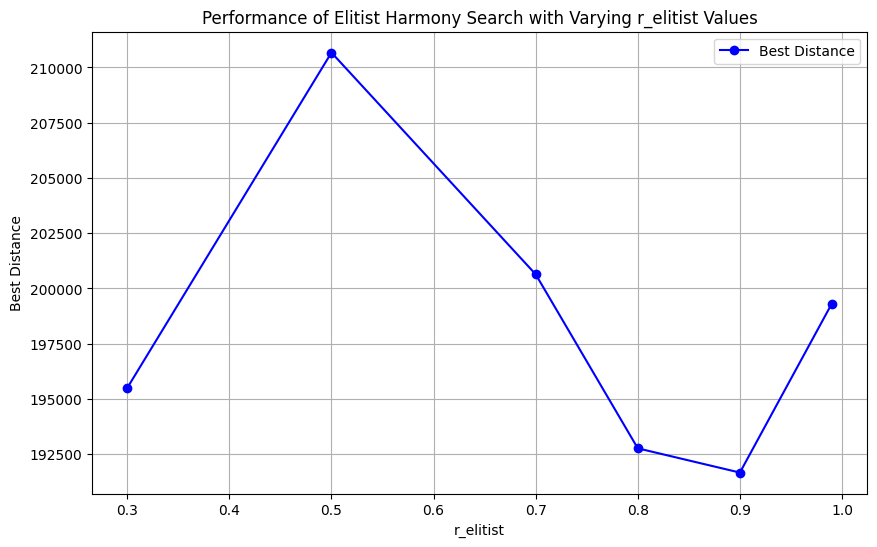

In [95]:
cities = load_tsp_data("data/tsp/d493.tsp")
D = compute_distance_matrix(cities)

test_elitist_harmony_with_varying_r_elitist(
    cities, D, r_elitist_values, harmony_memory_size, r_accept, elitist_size, max_iter)

Testing with r_elitist: 0.3
Best distance for r_elitist 0.3: 3430612.7906120024
Testing with r_elitist: 0.5
Best distance for r_elitist 0.5: 3410185.6780952965
Testing with r_elitist: 0.7
Best distance for r_elitist 0.7: 3402380.70000083
Testing with r_elitist: 0.8
Best distance for r_elitist 0.8: 3350557.070209674
Testing with r_elitist: 0.9
Best distance for r_elitist 0.9: 3483246.209713717
Testing with r_elitist: 0.99
Best distance for r_elitist 0.99: 3590622.883433945


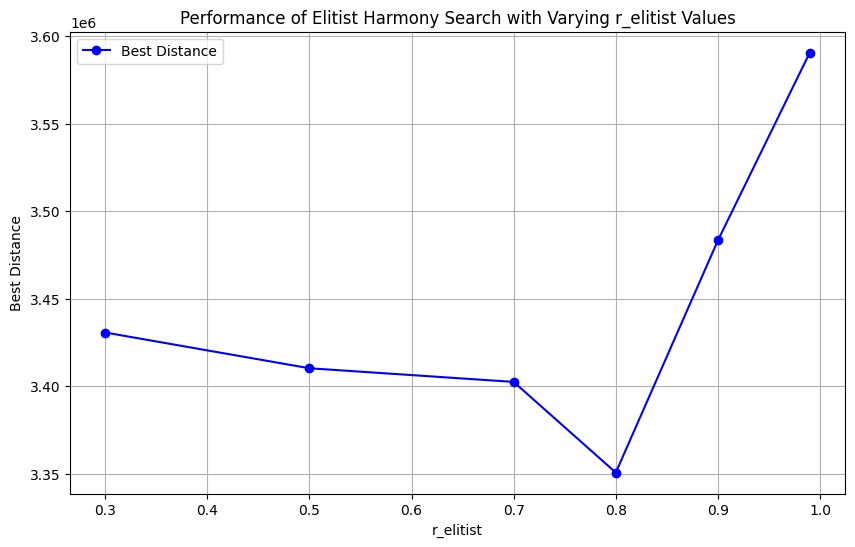

In [104]:
cities = load_tsp_data("data/tsp/pr1002.tsp")
D = compute_distance_matrix(cities)

test_elitist_harmony_with_varying_r_elitist(
    cities, D, r_elitist_values, harmony_memory_size, r_accept, elitist_size, max_iter)

Testing with r_elitist: 0.3
Best distance for r_elitist 0.3: 1227445.862302614
Testing with r_elitist: 0.5
Best distance for r_elitist 0.5: 1170021.6199027917
Testing with r_elitist: 0.7
Best distance for r_elitist 0.7: 1120176.3931802108
Testing with r_elitist: 0.8
Best distance for r_elitist 0.8: 1105870.8683173954
Testing with r_elitist: 0.9
Best distance for r_elitist 0.9: 1095454.698920051
Testing with r_elitist: 0.99
Best distance for r_elitist 0.99: 1135894.153828449


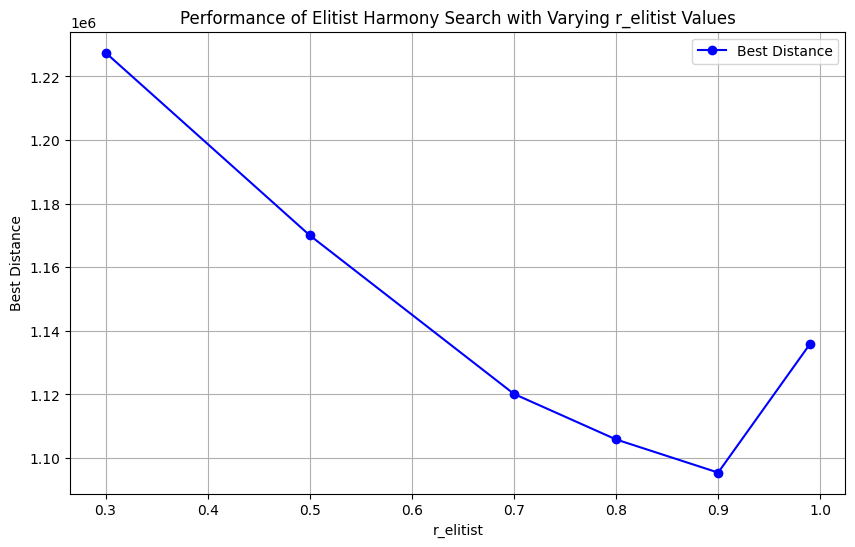

In [106]:
cities = load_tsp_data("data/tsp/d1655.tsp")
D = compute_distance_matrix(cities)

test_elitist_harmony_with_varying_r_elitist(
    cities, D, r_elitist_values, harmony_memory_size, r_accept, elitist_size, max_iter)

Testing with r_elitist: 0.3
Best distance for r_elitist 0.3: 8353990.816748791
Testing with r_elitist: 0.5
Best distance for r_elitist 0.5: 8119796.705460857
Testing with r_elitist: 0.7
Best distance for r_elitist 0.7: 7948487.438754813
Testing with r_elitist: 0.8
Best distance for r_elitist 0.8: 7881455.303173403
Testing with r_elitist: 0.9
Best distance for r_elitist 0.9: 7658835.93478323
Testing with r_elitist: 0.99
Best distance for r_elitist 0.99: 7981260.429461254


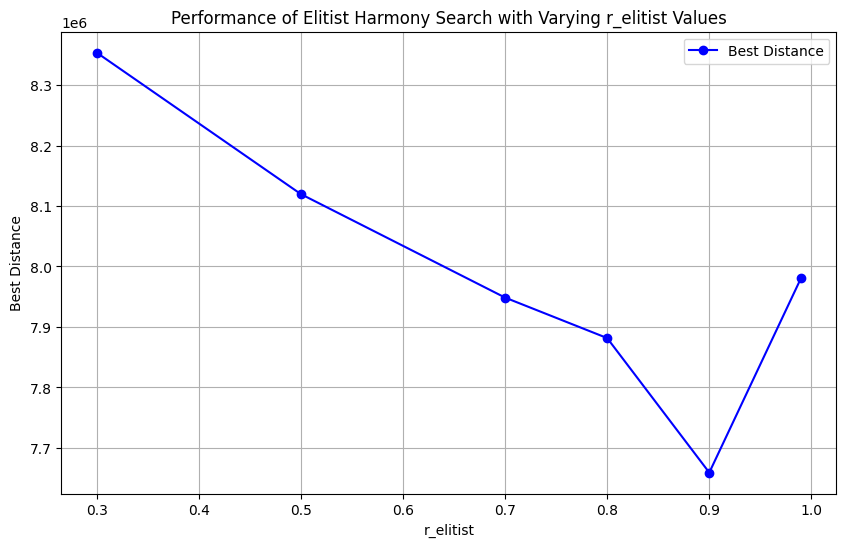

In [107]:
cities = load_tsp_data("data/tsp/pr2392.tsp")
D = compute_distance_matrix(cities)

test_elitist_harmony_with_varying_r_elitist(
    cities, D, r_elitist_values, harmony_memory_size, r_accept, elitist_size, max_iter)

## Running Tests
   - The following code runs the 4 Harmony Search algorithms on a given TSP file.
   - Parameters used (similar to the paper):
     - `harmony_memory_size = 20`
     - `r_accept = 0.999`
     - `r_elitist = 0.9`
     - `elitist_size = 4`
     - `r_pitch = 0.01`
     - `max_iter = 100000`



Running for dataset: tsp_datasets/berlin52.tsp
HS best distance: 8308.439008905032, Time: 15.28 seconds
EHS best distance: 7740.670826698567, Time: 12.70 seconds
IHS best distance: 10392.149656986354, Time: 7.83 seconds
EIHS best distance: 10499.137004208014, Time: 6.48 seconds
Results for berlin52.tsp saved to results_table.csv


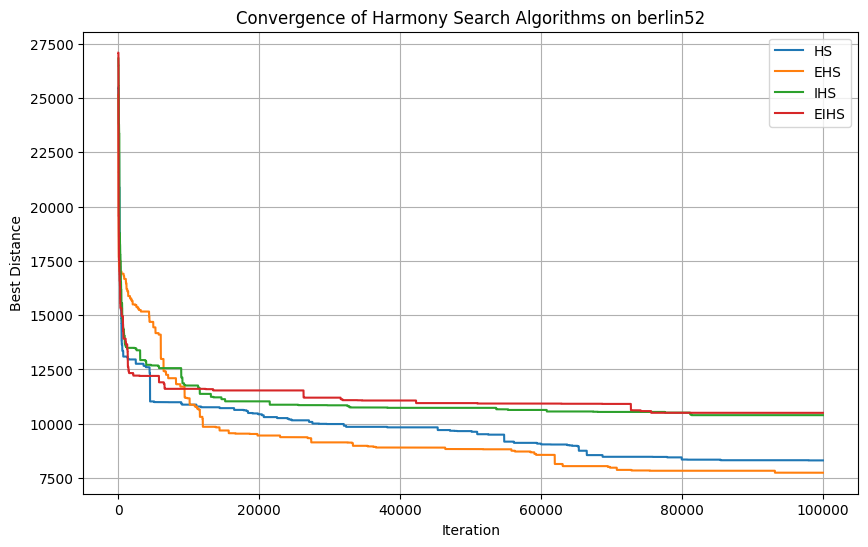

Convergence plot saved to plots/convergence_berlin52.png
Running for dataset: tsp_datasets/kroE100.tsp
HS best distance: 39727.112800299234, Time: 27.95 seconds
EHS best distance: 47430.76491165908, Time: 24.71 seconds
IHS best distance: 36290.60495593326, Time: 16.30 seconds
EIHS best distance: 37197.38083259521, Time: 13.92 seconds
Results for kroE100.tsp saved to results_table.csv


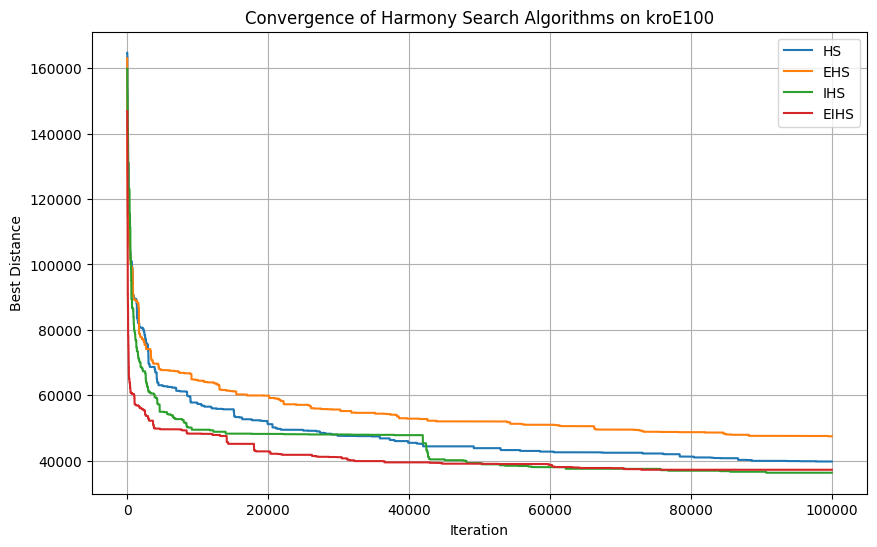

Convergence plot saved to plots/convergence_kroE100.png
Running for dataset: tsp_datasets/a280.tsp
HS best distance: 5904.375439473302, Time: 80.11 seconds
EHS best distance: 7753.500694842275, Time: 73.57 seconds
IHS best distance: 6940.424109832431, Time: 64.17 seconds
EIHS best distance: 7220.322110671781, Time: 53.52 seconds
Results for a280.tsp saved to results_table.csv


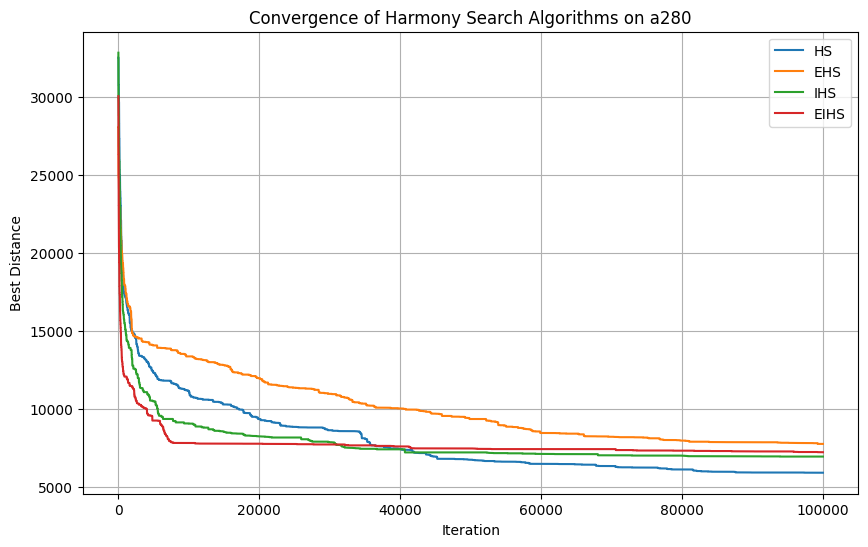

Convergence plot saved to plots/convergence_a280.png
Running for dataset: tsp_datasets/d493.tsp
HS best distance: 95791.78397078946, Time: 149.21 seconds
EHS best distance: 99571.6630721205, Time: 132.98 seconds
IHS best distance: 79894.38165497026, Time: 143.54 seconds
EIHS best distance: 91878.20526319901, Time: 139.90 seconds
Results for d493.tsp saved to results_table.csv


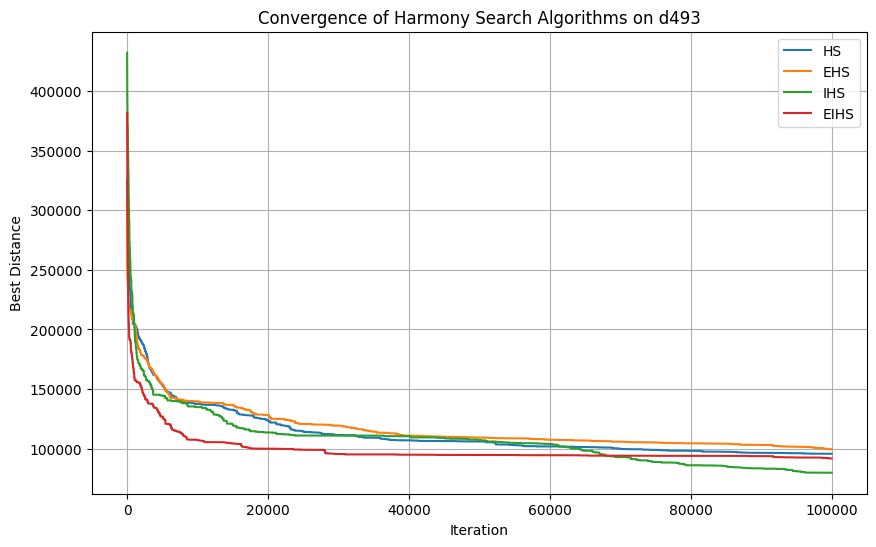

Convergence plot saved to plots/convergence_d493.png
Running for dataset: tsp_datasets/d657.tsp
HS best distance: 217057.9973046506, Time: 202.34 seconds
EHS best distance: 179214.2216597197, Time: 190.12 seconds
IHS best distance: 227036.726415508, Time: 231.29 seconds
EIHS best distance: 175252.23877989638, Time: 185.60 seconds
Results for d657.tsp saved to results_table.csv


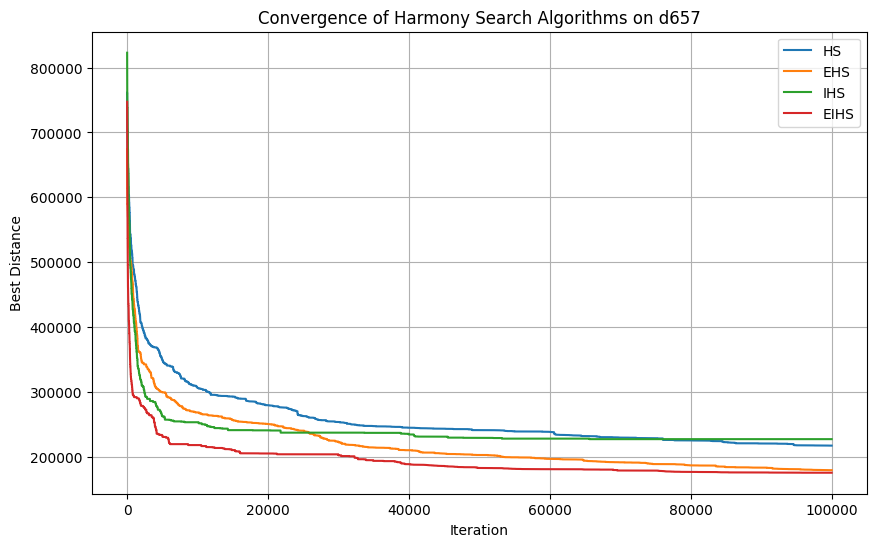

Convergence plot saved to plots/convergence_d657.png
Running for dataset: tsp_datasets/pr1002.tsp
HS best distance: 1597904.1130688388, Time: 327.54 seconds
EHS best distance: 1556456.0977112448, Time: 295.94 seconds
IHS best distance: 1523646.5186816792, Time: 456.57 seconds
EIHS best distance: 1110208.5676342912, Time: 367.41 seconds
Results for pr1002.tsp saved to results_table.csv


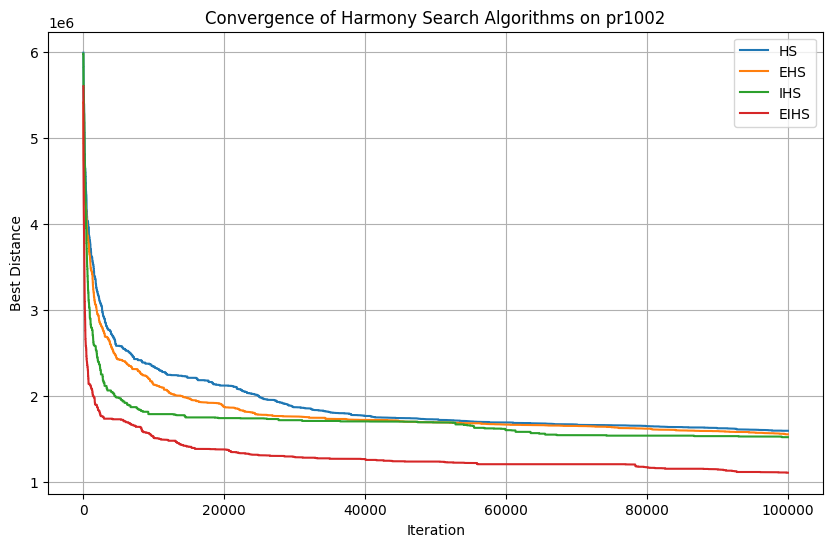

Convergence plot saved to plots/convergence_pr1002.png
Running for dataset: tsp_datasets/d1291.tsp
HS best distance: 418030.40607437445, Time: 442.45 seconds
EHS best distance: 419602.878930162, Time: 393.29 seconds
IHS best distance: 404424.9188001134, Time: 695.23 seconds
EIHS best distance: 338555.01825809263, Time: 573.19 seconds
Results for d1291.tsp saved to results_table.csv


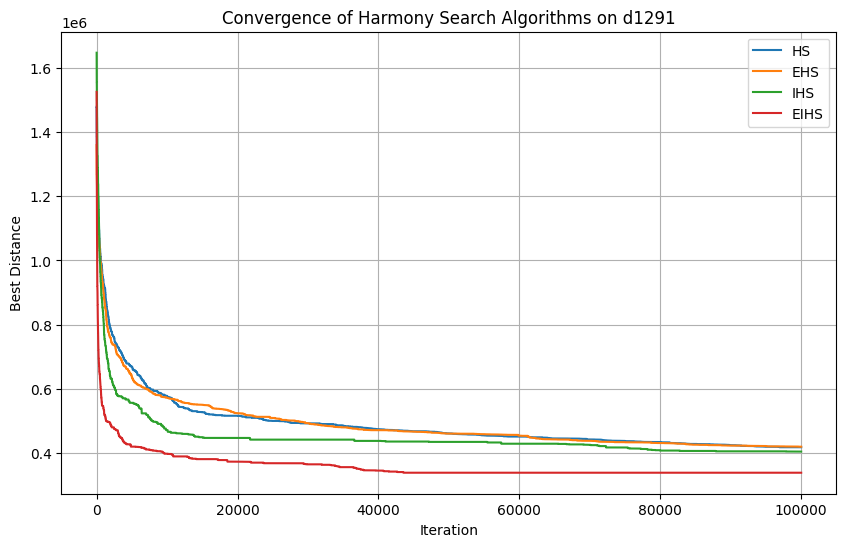

Convergence plot saved to plots/convergence_d1291.png
Running for dataset: tsp_datasets/u1432.tsp
HS best distance: 899079.0367070241, Time: 514.38 seconds
EHS best distance: 892356.2346438651, Time: 459.82 seconds
IHS best distance: 972672.2589827117, Time: 861.13 seconds
EIHS best distance: 836414.3167314958, Time: 697.94 seconds
Results for u1432.tsp saved to results_table.csv


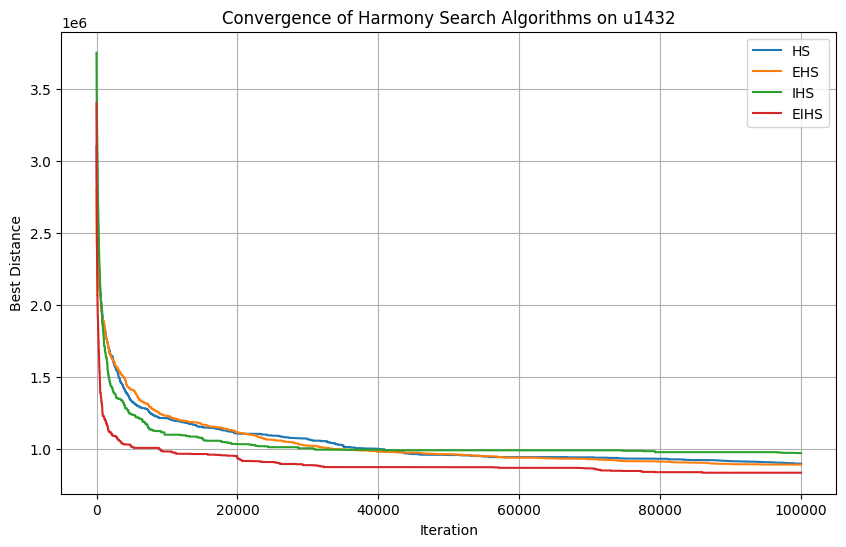

Convergence plot saved to plots/convergence_u1432.png
Running for dataset: tsp_datasets/d1655.tsp
HS best distance: 545946.2844871983, Time: 617.27 seconds
EHS best distance: 539067.1890119346, Time: 553.30 seconds
IHS best distance: 508666.288360922, Time: 1098.49 seconds
EIHS best distance: 421042.866912401, Time: 927.49 seconds
Results for d1655.tsp saved to results_table.csv


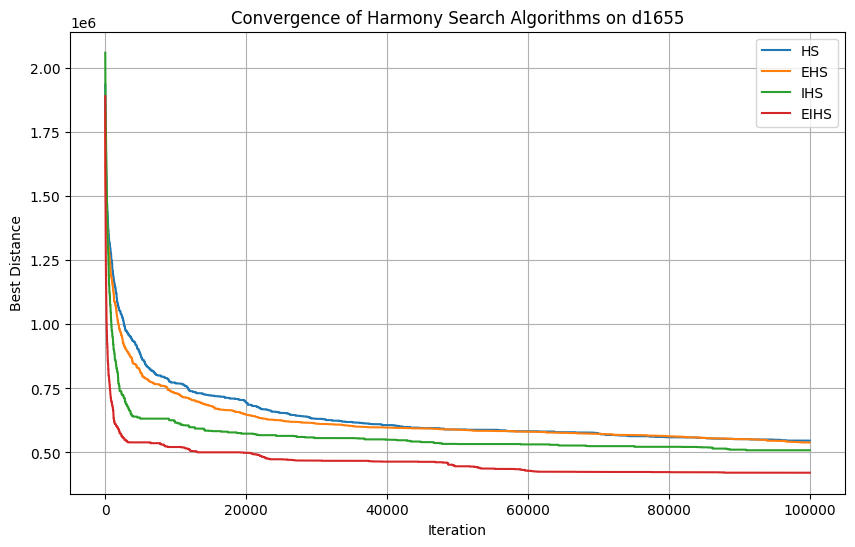

Convergence plot saved to plots/convergence_d1655.png
Running for dataset: tsp_datasets/pr2392.tsp
HS best distance: 4205430.890688747, Time: 1039.95 seconds
EHS best distance: 3934990.9020999228, Time: 846.08 seconds
IHS best distance: 3533664.6290804823, Time: 2173.83 seconds
EIHS best distance: 2971770.1931518754, Time: 1756.60 seconds
Results for pr2392.tsp saved to results_table.csv


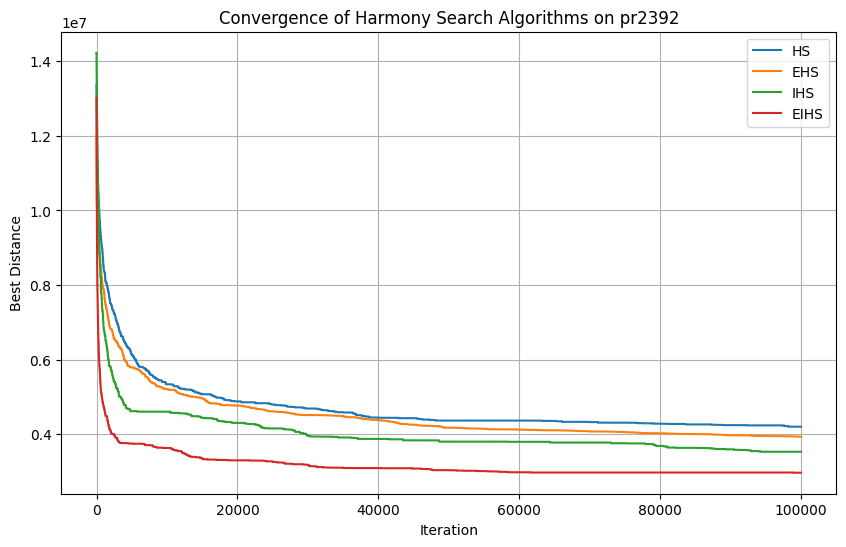

Convergence plot saved to plots/convergence_pr2392.png


In [48]:
datasets = [
    "data/tsp/berlin52.tsp",
    "data/tsp/kroE100.tsp",
    "data/tsp/a280.tsp",
    "data/tsp/d493.tsp",
    "data/tsp/d657.tsp",
    "data/tsp/pr1002.tsp",
    "data/tsp/d1291.tsp",
    "data/tsp/u1432.tsp",
    "data/tsp/d1655.tsp",
    "data/tsp/pr2392.tsp"
]

for dataset in datasets:
    print(f"Running for dataset: {dataset}")
    run_harmony_search_tests(dataset, 100000)

- the tests ran for like 5 hours and I managed to gather the results, but the output of the cell disappeared


### Conclusions from TSP Benchmark Tests

Based on the table above, we can draw the following key conclusions:

- **EHS, EIHS consistently outperformed HS, IHS** on all large TSP instances (e.g., `pr1002`, `d1291`, `d1655`, `pr2392`), confirming that **elitism improves solution quality** on big sized TSP problems.
- **IHS showed better performance than HS** in most datasets, especially mid-to-large ones (`kroE100`, `d493`, `pr1002`), thanks to the nearest neighbor-based pitch adjustment.
- **EHS was not always better than HS**; in some smaller or medium instances (`a280`, `kroE100`, `d493`), it even performed worse for my implmenetation, probably because elitism is causing the algorithm to focus too much on early good solutions and get stuck there.
- **Execution time was lower** for EHS and EIHS compared to IHS in many cases, especially for large datasets.They reuse better solutions more efficiently, reducing random choices and fallback operations, which speeds up convergence.


In summary, **EIHS is the most robust and effective variant** among the four tested, combining the strengths of both problem-specific heuristics (IHS) and strategic memory selection (EHS).


### TSP Test Results – Best Distance, Time, and % Improvement

| Method | Dataset        | Best Distance     | Time (s)      | Δ (%)                       |
|--------|----------------|-------------------|---------------|-----------------------------|
| HS     | berlin52.tsp   | 8308.439009       | 15.27770734   | —                           |
| EHS    | berlin52.tsp   | 7740.670827       | 12.70109296   | +6.83% vs HS                |
| IHS    | berlin52.tsp   | 10392.14966       | 7.827011585   | —                           |
| EIHS   | berlin52.tsp   | 10499.137         | 6.483909607   | -1.03% vs IHS               |
| HS     | kroE100.tsp    | 39727.1128        | 27.95200086   | —                           |
| EHS    | kroE100.tsp    | 47430.76491       | 24.70550227   | -19.40% vs HS               |
| IHS    | kroE100.tsp    | 36290.60496       | 16.29502368   | —                           |
| EIHS   | kroE100.tsp    | 37197.38083       | 13.92035794   | -2.50% vs IHS               |
| HS     | a280.tsp       | 5904.375439       | 80.11110067   | —                           |
| EHS    | a280.tsp       | 7753.500695       | 73.57371855   | -31.34% vs HS               |
| IHS    | a280.tsp       | 6940.42411        | 64.17258286   | —                           |
| EIHS   | a280.tsp       | 7220.322111       | 53.52204156   | -4.03% vs IHS               |
| HS     | d493.tsp       | 95791.78397       | 149.2059894   | —                           |
| EHS    | d493.tsp       | 99571.66307       | 132.9759843   | -3.95% vs HS                |
| IHS    | d493.tsp       | 79894.38165       | 143.5421586   | —                           |
| EIHS   | d493.tsp       | 91878.20526       | 139.8981493   | -15.00% vs IHS              |
| HS     | d657.tsp       | 217057.9973       | 202.3366275   | —                           |
| EHS    | d657.tsp       | 179214.2217       | 190.1160934   | +17.45% vs HS               |
| IHS    | d657.tsp       | 227036.7264       | 231.2945249   | —                           |
| EIHS   | d657.tsp       | 175252.2388       | 185.5992713   | +22.83% vs IHS              |
| HS     | pr1002.tsp     | 1597904.113       | 327.5364461   | —                           |
| EHS    | pr1002.tsp     | 1556456.098       | 295.9374037   | +2.59% vs HS                |
| IHS    | pr1002.tsp     | 1523646.519       | 456.571172    | —                           |
| EIHS   | pr1002.tsp     | 1110208.568       | 367.4128356   | +27.12% vs IHS              |
| HS     | d1291.tsp      | 418030.4061       | 442.448596    | —                           |
| EHS    | d1291.tsp      | 419602.8789       | 393.2883027   | -0.38% vs HS                |
| IHS    | d1291.tsp      | 404424.9188       | 695.2327976   | —                           |
| EIHS   | d1291.tsp      | 338555.0183       | 573.192323    | +16.29% vs IHS              |
| HS     | u1432.tsp      | 899079.0367       | 514.377883    | —                           |
| EHS    | u1432.tsp      | 892356.2346       | 459.822962    | +0.75% vs HS                |
| IHS    | u1432.tsp      | 972672.259        | 861.1311429   | —                           |
| EIHS   | u1432.tsp      | 836414.3167       | 697.9445758   | +14.02% vs IHS              |
| HS     | d1655.tsp      | 545946.2845       | 617.2732356   | —                           |
| EHS    | d1655.tsp      | 539067.189        | 553.2955184   | +1.26% vs HS                |
| IHS    | d1655.tsp      | 508666.2884       | 1098.494649   | —                           |
| EIHS   | d1655.tsp      | 421042.8669       | 927.4936111   | +17.24% vs IHS              |
| HS     | pr2392.tsp     | 4205430.891       | 1039.948745   | —                           |
| EHS    | pr2392.tsp     | 3934990.902       | 846.0830545   | +6.43% vs HS                |
| IHS    | pr2392.tsp     | 3533664.629       | 2173.825779   | —                           |
| EIHS   | pr2392.tsp     | 2971770.193       | 1756.595488   | +15.90% vs IHS              |


### Comparison of EIHS Results vs. Paper (6 Common Datasets)

| Dataset     | EIHS Distance | EIHS (Paper) Distance | Improvement (Mine vs Paper) |
|-------------|------------------------|------------------------|-------------------------------|
| d493.tsp    | 91878.21               | 59400                  | -54.63%                       |
| d657.tsp    | 175252.24              | 101727                 | -72.32%                       |
| pr1002.tsp  | 1110208.57             | 684012                 | -62.35%                       |
| d1291.tsp   | 338555.02              | 178252                 | -89.91%                       |
| d1655.tsp   | 421042.87              | 225317                 | -86.84%                       |
| pr2392.tsp  | 2971770.19             | 1625572                | -82.88%                       |

> Note: Negative improvement indicates my results are worse than the paper's. This may be due to implementation differences.
